# Introduction

# Packages

In [1]:
import music21
import numpy as np
import pandas as pd
import os

from collections import Counter

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Data

## Extract Data From Midi to Dataframe

In [2]:
# def function to get the notes as text from midi files
def extract_notes(midi):
    notes = []
    pick = None
    songs = music21.instrument.partitionByInstrument(midi)
    for part in songs.parts:
        pick = part.recurse()
        for element in pick:
            if isinstance(element, music21.note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, music21.chord.Chord):
                notes.append(".".join(str(n) for n in element.normalOrder))
    return ' - '.join(notes)


# store mdi files in a dictionary with artist as keys
folder_path = 'data/music_classic'
artist_midi_dict = {}
cnt = 0
for artist_folder in os.listdir(folder_path):
    print(artist_folder)
    
    filepath = folder_path + '/' + artist_folder+'/'

    midis = []
    for i in os.listdir(filepath):
        if i.endswith('.mid'):
            tr = filepath + i
            try:
                midi = music21.converter.parse(tr)
                midis.append(extract_notes(midi))
            except:
                continue
            
    artist_midi_dict[artist_folder] = midis
    
    cnt += 1
    if cnt == 5:
        break


# create a dataframe with artist and notes
df = pd.DataFrame(columns=['artist', 'midi'])
for artist in artist_midi_dict.keys():
    for midi in artist_midi_dict[artist]:
        df = df.append({'artist':artist, 'midi':midi}, ignore_index=True)

mendelssohn
haydn
grieg
debussy
bach


/tmp/ipykernel_122059/2442093044.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'artist':artist, 'midi':midi}, ignore_index=True)
/tmp/ipykernel_122059/2442093044.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'artist':artist, 'midi':midi}, ignore_index=True)
/tmp/ipykernel_122059/2442093044.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'artist':artist, 'midi':midi}, ignore_index=True)
/tmp/ipykernel_122059/2442093044.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'artist':artist, 'midi':midi}, ignore_index=True)
/tmp/ipykernel_122059/2442093044.py:

# One to One

## Data Selection

In [62]:
# get specific artist
artist = 'haydn'

# filter dataframe for artist
data = df[df['artist'] == artist]

# get all notes
notes = ' - '.join(data['midi'].tolist()).split(' - ')

## EDA

In [63]:
# apply counter to get the frequency of each note
counter_notes = Counter(notes)

# sort counter
counter_notes = dict(sorted(counter_notes.items(), key=lambda item: item[1], reverse=True))

# get unique notes
unique_notes = list(counter_notes.keys())

# get frequency of each note
freq_notes = list(counter_notes.values())

# print average, most common and least common note
print('Average note frequency: ', np.mean(freq_notes))
print('Most common note: ', unique_notes[np.argmax(freq_notes)], np.max(freq_notes))
print('Least common note: ', unique_notes[np.argmin(freq_notes)], np.min(freq_notes))

Average note frequency:  144.54748603351956
Most common note:  G4 1449
Least common note:  G#1 1


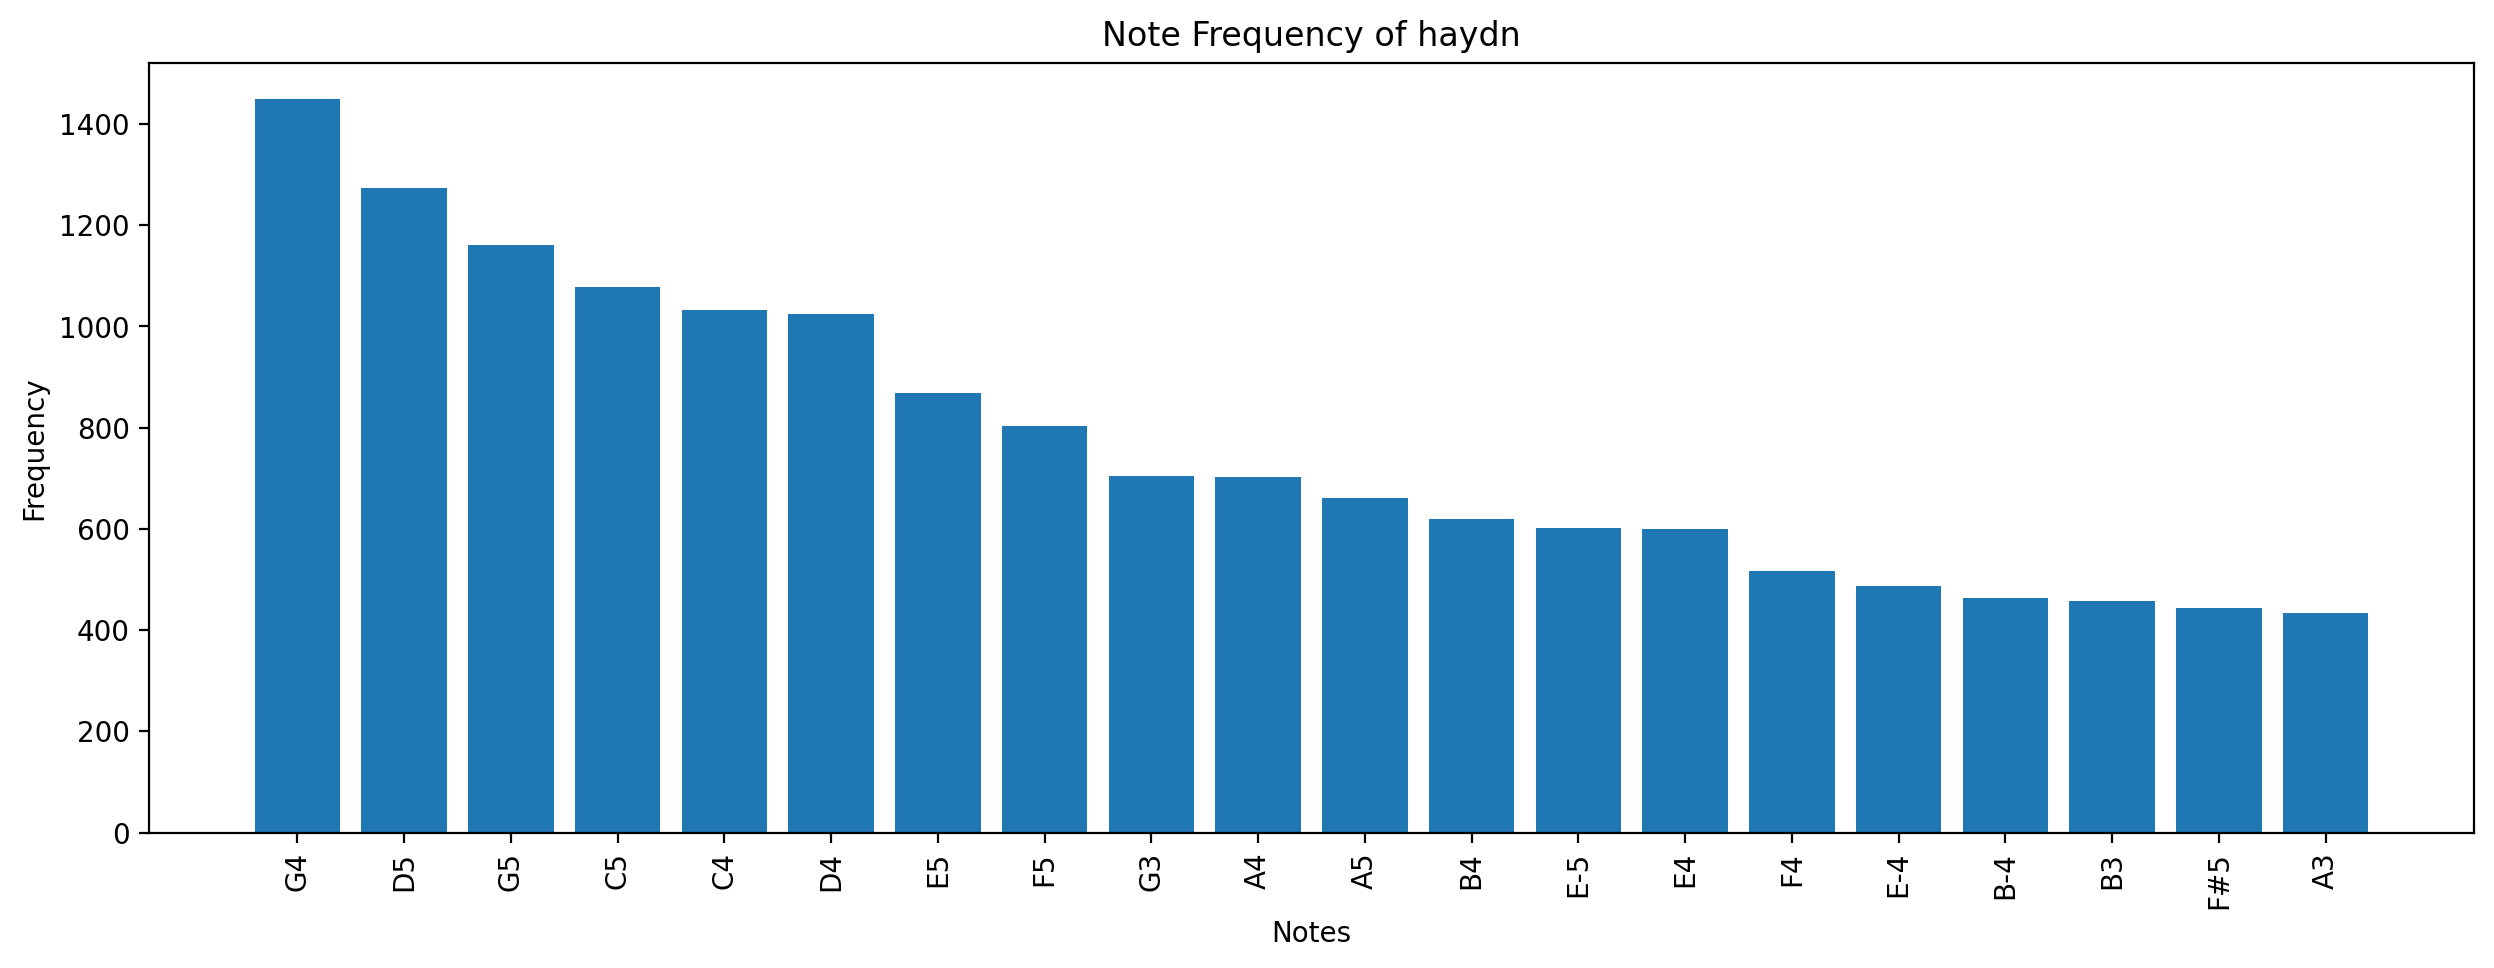

In [64]:
# bar plot of note frequency of 20 most common notes
plt.figure(figsize=(15, 5))
plt.bar(unique_notes[:20], freq_notes[:20])
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.xlabel('Notes')
plt.title('Note Frequency of ' + artist)
plt.show()

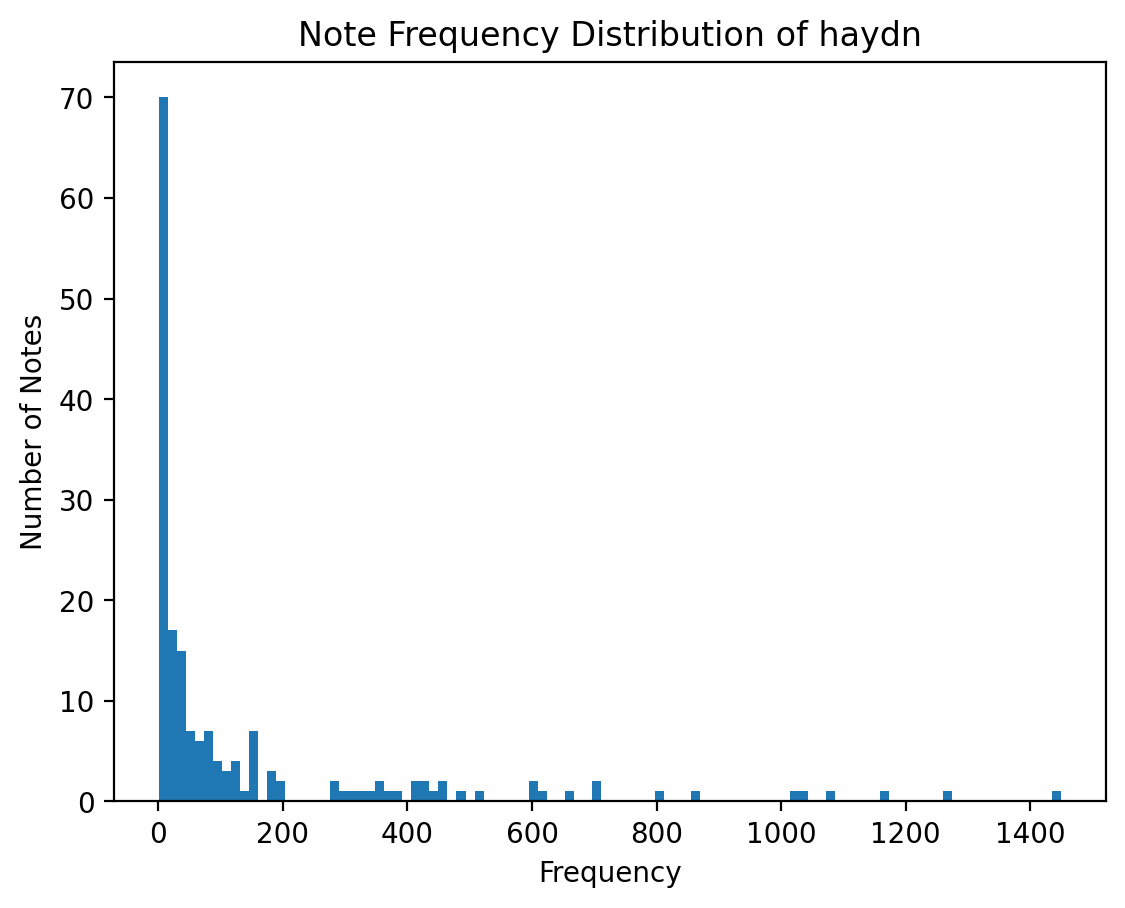

In [65]:
plt.hist(freq_notes, bins=100)
plt.xlabel('Frequency')
plt.ylabel('Number of Notes')
plt.title('Note Frequency Distribution of ' + artist)
plt.show()

## Filtering

In [66]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(counter_notes.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))


#Eleminating the rare notes
for element in notes:
    if element in rare_note:
        notes.remove(element)

print("Length of Corpus after elemination the rare notes:", len(notes))

Total number of notes that occur less than 100 times: 125


Length of Corpus after elemination the rare notes: 23531


## Data For Training

In [82]:
# Encoding string notes to integers
note_labels = sorted(set(item for item in notes))
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(note_labels)

# Create a dictionary to map notes to integers
note_to_int = dict(zip(note_labels, integer_encoded))

# Prepare input-output pairs
sequence_length = 10 # Length of input sequences because one to one
network_input = []
network_output = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# Reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

# Normalize input
network_input = network_input / float(len(note_labels))

# Convert output to one-hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
network_output = onehot_encoder.fit_transform(np.array(network_output).reshape(-1, 1))

In [83]:
# Split data into training and validation sets
train_size = int(len(network_input) * 0.8)
train_input = network_input[:train_size]
train_output = network_output[:train_size]
val_input = network_input[train_size:]
val_output = network_output[train_size:]

# Create a custom dataset
class MusicDataset(Dataset):
    def __init__(self, input, output):
        self.input = input
        self.output = output

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        return torch.tensor(self.input[idx]).float(), torch.tensor(self.output[idx])
    

# Create dataloaders
batch_size = 32
train_dataset = MusicDataset(train_input, train_output)
val_dataset = MusicDataset(val_input, val_output)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [84]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(MusicRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Model instantiation
input_size = 1  # As we have normalized input
hidden_size = 256
output_size = len(note_labels)  # Number of unique notes
num_layers = 2
dropout = 0.1

model = MusicRNN(input_size, hidden_size, output_size, num_layers, dropout)


In [85]:
# training parameters
learning_rate = 0.0001
num_epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists for storing metrics
epoch_losses = []
epoch_accuracies = []

# Train model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(train_loader):
        model.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Loss accumulation
        epoch_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update train correct, total
        total_predictions += labels.size(0)
        correct_predictions += (predicted == torch.max(labels, 1)[1]).sum().item()

    # Average loss and accuracy for the epoch
    avg_epoch_loss = epoch_loss / n_total_steps
    epoch_accuracy = 100 * correct_predictions / total_predictions

    # Append to the lists
    epoch_losses.append(avg_epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%') 

Epoch [1/100], Loss: 3.8527, Accuracy: 5.97%
Epoch [2/100], Loss: 3.7687, Accuracy: 6.12%
Epoch [3/100], Loss: 3.7686, Accuracy: 6.08%
Epoch [4/100], Loss: 3.7667, Accuracy: 6.25%
Epoch [5/100], Loss: 3.7665, Accuracy: 6.12%
Epoch [6/100], Loss: 3.7668, Accuracy: 6.37%
Epoch [7/100], Loss: 3.7678, Accuracy: 6.11%
Epoch [8/100], Loss: 3.7654, Accuracy: 6.28%
Epoch [9/100], Loss: 3.7673, Accuracy: 6.05%
Epoch [10/100], Loss: 3.7669, Accuracy: 6.27%
Epoch [11/100], Loss: 3.7667, Accuracy: 6.27%
Epoch [12/100], Loss: 3.7662, Accuracy: 5.94%
Epoch [13/100], Loss: 3.7670, Accuracy: 6.20%
Epoch [14/100], Loss: 3.7668, Accuracy: 6.23%
Epoch [15/100], Loss: 3.7660, Accuracy: 6.20%


KeyboardInterrupt: 

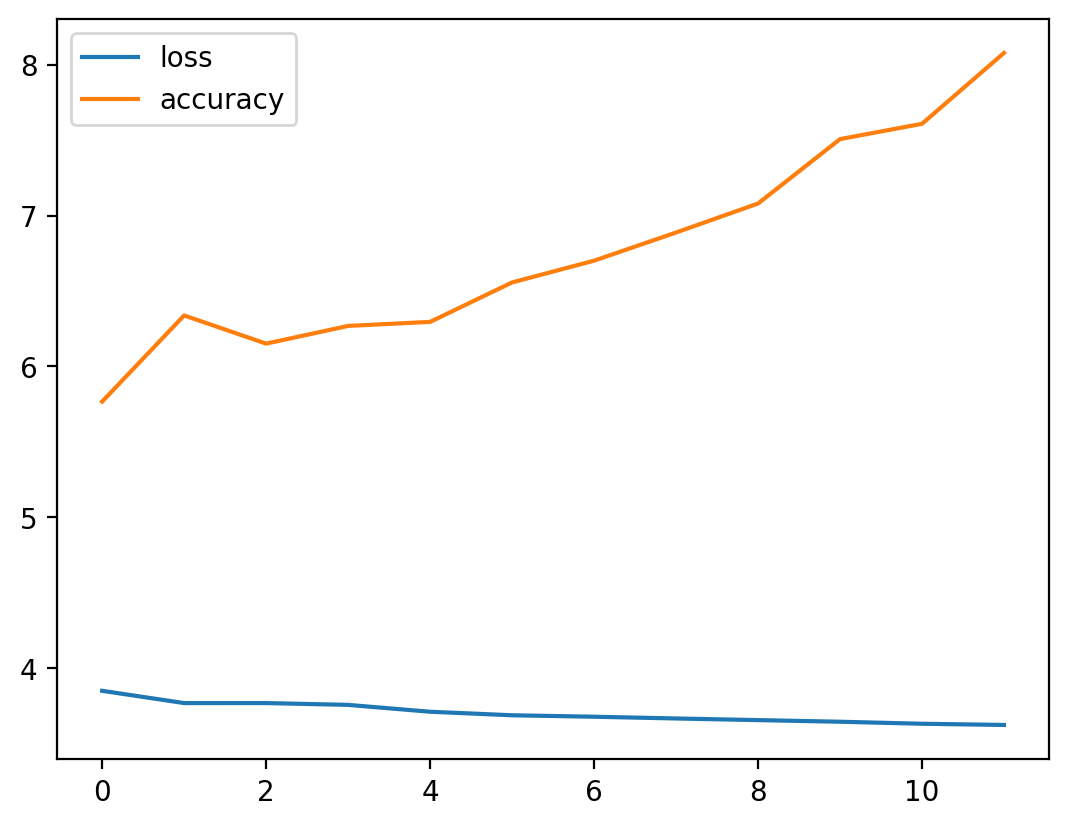

In [ ]:
# plot loss and accuracy
plt.plot(epoch_losses, label='loss')
plt.plot(epoch_accuracies, label='accuracy')
plt.legend()
plt.show()

In [15]:
loss, train_loss

(tensor(3.6941, grad_fn=<NllLossBackward0>), 26619.48533630371)